# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51295, 7)
Label size [input_size,]:		 (51295,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


## Simple FCNN

As a first step, we would like to see how a simple FCNN performs.

In [4]:
from preprocess import preprocess_split
from model import SimpleFCNN, train_one_epoch, test

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=1e-4)
acc_metric = torchmetrics.R2Score()  # TODO: maybe find a better accuracy metric?

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:",device,"\n")
simple_fcnn.to(device)

# Standardize your data
sc = StandardScaler()
data_scaled = sc.fit_transform(data.reshape(-1, data.shape[1]))

# Data preparation
train_set, val_set, test_set = preprocess_split(data_scaled, labels, train_split=0.7, val_split=0.15)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(simple_fcnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(simple_fcnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )


Device: cuda 

Epoch 05	 Train loss: 0.0329	 Train acc: 0.4191	Val loss: 0.0361	 Val acc: 0.4239
Epoch 10	 Train loss: 0.0291	 Train acc: 0.4981	Val loss: 0.0326	 Val acc: 0.4998
Epoch 15	 Train loss: 0.0279	 Train acc: 0.5327	Val loss: 0.0309	 Val acc: 0.5336
Epoch 20	 Train loss: 0.0272	 Train acc: 0.5536	Val loss: 0.0309	 Val acc: 0.5542
Epoch 25	 Train loss: 0.0269	 Train acc: 0.5676	Val loss: 0.0296	 Val acc: 0.5680
Epoch 30	 Train loss: 0.0263	 Train acc: 0.5782	Val loss: 0.0287	 Val acc: 0.5786
Epoch 35	 Train loss: 0.0260	 Train acc: 0.5864	Val loss: 0.0288	 Val acc: 0.5867
Epoch 40	 Train loss: 0.0256	 Train acc: 0.5931	Val loss: 0.0289	 Val acc: 0.5933
Epoch 45	 Train loss: 0.0252	 Train acc: 0.5988	Val loss: 0.0275	 Val acc: 0.5990
Epoch 50	 Train loss: 0.0250	 Train acc: 0.6037	Val loss: 0.0281	 Val acc: 0.6038


In [5]:
# How does the model perform on unseen data?

test_loss, test_acc = test(simple_fcnn, device, test_loader, criterion, acc_metric)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.0266	 Final test acc: 0.6041


Compare with previous data

In [6]:
z_spec_0 = np.loadtxt("./data/specz_photoz.csv", delimiter=",", usecols=0, skiprows=1)
z_photo_0 = np.loadtxt("./data/specz_photoz.csv", delimiter=",", usecols=1, skiprows=1)
loss_0 = mean_squared_error(z_spec_0, z_photo_0)
print('MES of previous work', loss_0)

label_list = []
pred_list = []
for data, label in test_set:
    data = data.to(device)
    label_list.append(label.item())
    pred = simple_fcnn(data)
    pred_list.append(pred.item())
loss_1 = mean_squared_error(label_list, pred_list)
print('MES of our work using test dataset', loss_1)

MES of previous work 0.04104375867657735
MES of our work using test dataset 0.02660867267275683


Next, we would like to visualize how our training went!

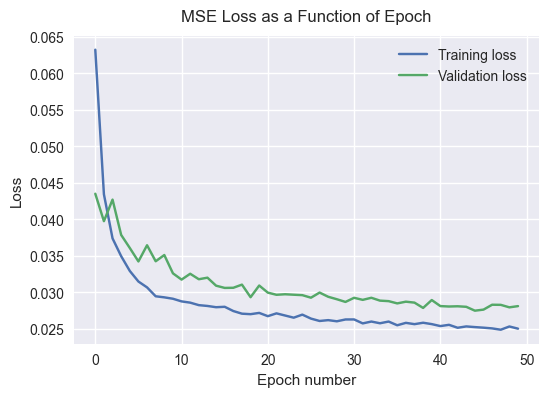

In [7]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)

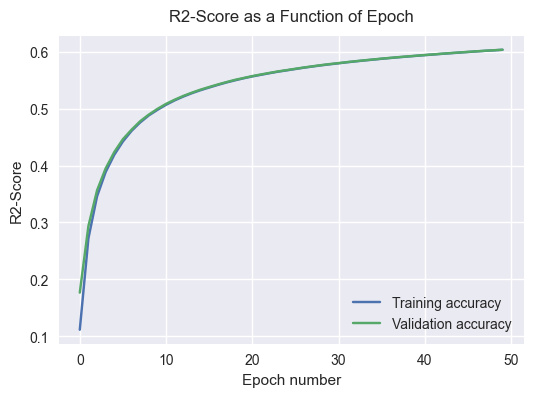

In [8]:
plot_accuracy(acc_list, val_acc_list)

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

0.5858843250706862


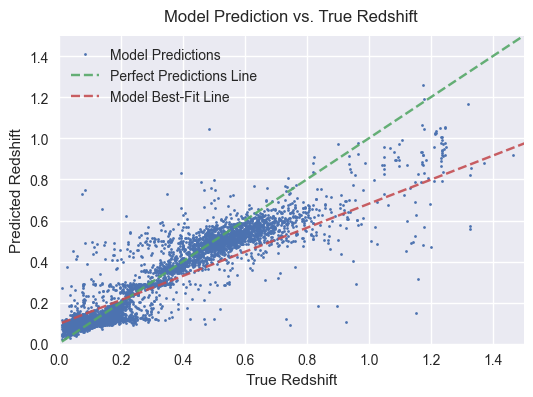

In [9]:
from visualize import visualize_predictions

visualize_predictions(test_set, simple_fcnn, device=device, xrange=(0,1.5), yrange=(0,1.5))

## 1D CNN

In [10]:
#TODO!